In [1]:
teams = {
        "Atlanta Hawks": 1610612737,
        "Boston Celtics": 1610612738,
        "Brooklyn Nets": 1610612751,
        "Charlotte Bobcats": 1610612766,
        "Charlotte Hornets": 1610612766,
        "Chicago Bulls": 1610612741,
        "Cleveland Cavaliers": 1610612739,
        "Dallas Mavericks": 1610612742,
        "Denver Nuggets": 1610612743,
        "Detroit Pistons": 1610612765,
        "Golden State Warriors": 1610612744,
        "Houston Rockets": 1610612745,
        "Indiana Pacers": 1610612754,
        "LA Clippers": 1610612746,
        "Los Angeles Clippers": 1610612746,
        "Los Angeles Lakers": 1610612747,
        "Memphis Grizzlies": 1610612763,
        "Miami Heat": 1610612748,
        "Milwaukee Bucks": 1610612749,
        "Minnesota Timberwolves": 1610612750,
        "New Jersey Nets": 1610612751,
        "New Orleans Hornets": 1610612740,
        "New Orleans Pelicans": 1610612740,
        "New York Knicks": 1610612752,
        "Oklahoma City Thunder": 1610612760,
        "Orlando Magic": 1610612753,
        "Philadelphia 76ers": 1610612755,
        "Phoenix Suns": 1610612756,
        "Portland Trail Blazers": 1610612757,
        "Sacramento Kings": 1610612758,
        "San Antonio Spurs": 1610612759,
        "Toronto Raptors": 1610612761,
        "Utah Jazz": 1610612762,
        "Washington Wizards": 1610612764,
    }

available_stats = {'W_PCT': 'Base',
                   'FG_PCT': 'Base',
                   'FG3_PCT': 'Base',
                   'FT_PCT': 'Base',
                   'REB': 'Base',
                   'AST': 'Base',
                   'TOV': 'Base',
                   'STL': 'Base',
                   'BLK': 'Base',
                   'PLUS_MINUS': 'Base',
                   'OFF_RATING': 'Advanced',
                   'DEF_RATING': 'Advanced',
                   'TS_PCT': 'Advanced'}


In [2]:
#from team_names import teams
from nba_api.stats.endpoints import teamdashboardbygeneralsplits, leaguedashteamstats
import time
import pandas as pd


def get_team_stats_dict(team, start_date, end_date, season='2020-21'):
    """
    Returns the stats for the specified team in a dataframe, default year is 2020-21
    :param team: Day of games scheduled in form 'mm/dd/yyyy'
    :param season: Day of games scheduled in form 'mm/dd/yyyy'
    :return: A dictionary of game matchups {home_team:[away_team]}
    """

    time.sleep(1)

    general_team_info = teamdashboardbygeneralsplits.TeamDashboardByGeneralSplits(team_id=teams[team],
                                                                                  per_mode_detailed='Per100Possessions',
                                                                                  season=season,
                                                                                  date_from_nullable=start_date,
                                                                                  date_to_nullable=end_date,

                                                                                  timeout=120)
    general_team_dict = general_team_info.get_normalized_dict()
    general_team_dashboard = general_team_dict['OverallTeamDashboard'][0]

    win_percentage = general_team_dashboard['W_PCT']
    fg_percentage = general_team_dashboard['FG_PCT']
    fg3_percentage = general_team_dashboard['FG3_PCT']
    ft_percentage = general_team_dashboard['FT_PCT']
    rebounds = general_team_dashboard['REB']
    assists = general_team_dashboard['AST']
    turnovers = general_team_dashboard['TOV']
    steals = general_team_dashboard['STL']
    blocks = general_team_dashboard['BLK']
    plus_minus = general_team_dashboard['PLUS_MINUS']

    advanced_team_info = teamdashboardbygeneralsplits.TeamDashboardByGeneralSplits(team_id=teams[team],
                                                                                   measure_type_detailed_defense='Advanced',
                                                                                   season=season,
                                                                                   date_from_nullable=start_date,
                                                                                   date_to_nullable=end_date,
                                                                                   
                                                                                   timeout=120)
    advanced_team_dict = advanced_team_info.get_normalized_dict()
    advanced_team_dashboard = advanced_team_dict['OverallTeamDashboard'][0]

    offensive_rating = advanced_team_dashboard['OFF_RATING']
    defensive_rating = advanced_team_dashboard['DEF_RATING']
    true_shooting_percentage = advanced_team_dashboard['TS_PCT']

    all_stats_dict = {
        'W_PCT': win_percentage,
        'FG_PCT': fg_percentage,
        'FG3_PCT': fg3_percentage,
        'FT_PCT': ft_percentage,
        'REB': rebounds,
        'AST': assists,
        'TOV': turnovers,
        'STL': steals,
        'BLK': blocks,
        'PLUS_MINUS': plus_minus,
        'OFF_RATING': offensive_rating,
        'DEF_RATING': defensive_rating,
        'TS_PCT': true_shooting_percentage
    }

    return all_stats_dict



In [3]:

from nba_api.stats.endpoints import leaguegamelog, scoreboard
#from team_names import teams


def get_match_results(date, season):
    """
    Returns the matchup and result of the game

    :param date: Day of games scheduled in form 'mm/dd/yyyy'
    :param season: Season in form of 'yyyy-yy'
    :return: [{Boston Celtics: Los Angeles Lakers}], ['W']
    """
    game_log = leaguegamelog.LeagueGameLog(season=season, league_id='00', date_from_nullable=date,
                                           date_to_nullable=date, season_type_all_star='Regular Season', timeout=120)
    game_log_dict = game_log.get_normalized_dict()
    list_of_teams = game_log_dict['LeagueGameLog']

    daily_match = {}
    win_loss = []

    for i in range(0, len(list_of_teams), 2):

        if '@' in list_of_teams[i]['MATCHUP']:

            away_team = list_of_teams[i]['TEAM_NAME']
            home_team = list_of_teams[i + 1]['TEAM_NAME']

            win_loss.append(list_of_teams[i + 1]['WL'])

        else:
            away_team = list_of_teams[i + 1]['TEAM_NAME']
            home_team = list_of_teams[i]['TEAM_NAME']
            win_loss.append(list_of_teams[i]['WL'])

        daily_match.update({home_team: away_team})

    match_results = [daily_match, win_loss]

    return match_results


def get_daily_matches(date):
    """
    This method creates a dictionary of daily game matchups.

    :param date: Day of games scheduled in form 'mm/dd/yyyy'
    :return: A dictionary of game matchups {home_team:away_team}
    """

    daily_match = scoreboard.Scoreboard(league_id='00', game_date=date, timeout=120)
    daily_match_dict = daily_match.get_normalized_dict()
    games = daily_match_dict['GameHeader']

    match = {}

    for game in games:

        home_team_id = game['HOME_TEAM_ID']

        for team, team_id in teams.items():
            if team_id == home_team_id:
                home_team = team

        away_team_id = game['VISITOR_TEAM_ID']

        for team, team_id in teams.items():
            if team_id == away_team_id:
                away_team = team

        match.update({home_team: away_team})

    return match


def main():
    print(get_daily_matches('02/03/21'))
    print(get_match_results('02/03/21', '2020-21'))


main()

{'Charlotte Hornets': 'Philadelphia 76ers', 'Milwaukee Bucks': 'Indiana Pacers', 'Atlanta Hawks': 'Dallas Mavericks', 'Cleveland Cavaliers': 'Los Angeles Clippers', 'Miami Heat': 'Washington Wizards', 'Chicago Bulls': 'New York Knicks', 'Oklahoma City Thunder': 'Houston Rockets', 'San Antonio Spurs': 'Minnesota Timberwolves', 'New Orleans Pelicans': 'Phoenix Suns', 'Sacramento Kings': 'Boston Celtics'}
[{'San Antonio Spurs': 'Minnesota Timberwolves', 'Chicago Bulls': 'New York Knicks', 'Cleveland Cavaliers': 'LA Clippers', 'Miami Heat': 'Washington Wizards', 'Milwaukee Bucks': 'Indiana Pacers', 'Atlanta Hawks': 'Dallas Mavericks', 'Sacramento Kings': 'Boston Celtics', 'Charlotte Hornets': 'Philadelphia 76ers', 'Oklahoma City Thunder': 'Houston Rockets', 'New Orleans Pelicans': 'Phoenix Suns'}, ['W', 'L', 'L', 'L', 'W', 'L', 'W', 'L', 'W', 'W']]


In [4]:
from datetime import date, timedelta
import pandas as pd
import requests

#from get_stats import get_team_stats_dict
#from get_matches import get_match_results
#from standardization import z_score, stat_std, stat_mean
#from available_stats import available_stats


# [{'Sacramento Kings': 'Boston Celtics', 'Charlotte Hornets': 'Philadelphia 76ers'}, ['W', 'L']]
# team stats is a dataframe
def to_dataframe(daily_games, start_date, end_date, season): #, mean_dict, std_dict):
    full_dataframe = []
    game_number = 0  # counter to match with the correct game
    daily_results = daily_games[1]  # win or loss for each game

    for home_team, away_team in daily_games[0].items():  # loops through matchups
        home_team_stats = get_team_stats_dict(home_team, start_date, end_date, season)
        away_team_stats = get_team_stats_dict(away_team, start_date, end_date, season)

        current_game = [home_team, away_team]

        for stat, stat_type in available_stats.items():
            current_game.append(home_team_stats[stat])

        for stat, stat_type in available_stats.items():
            current_game.append(away_team_stats[stat])


        #for stat, stat_type in available_stats.items():
        #    z_score_diff = z_score_difference(home_team_stats[stat], away_team_stats[stat], mean_dict[stat], std_dict[stat])

         #   current_game.append(z_score_diff)

        if daily_results[game_number] == 'W':
            result = 1
        else:
            result = 0

        current_game.append(result)
        game_number += 1

        print(current_game)

        full_dataframe.append(current_game)

    return full_dataframe



def date_range(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)
        

def training_set(start_year, start_month, start_day, end_year, end_month, end_day, season, season_start):
    start_date = date(start_year, start_month, start_day)
    end_date = date(end_year, end_month, end_day)

    total_games = []

    for single_date in date_range(start_date, end_date):
        current_date = single_date.strftime('%m/%d/%Y')
        print(current_date)

        previous_day = single_date - timedelta(days=1)
        previous_day_formatted = previous_day.strftime('%m/%d/%Y')

        #mean_std_dictionary = mean_std_dict(season_start, previous_day_formatted, season)
        #mean_dict = mean_std_dictionary[0]
        #std_dict = mean_std_dictionary[1]

        current_day_games = get_match_results(current_date, season)
        current_day_games_with_stats = to_dataframe(current_day_games, season_start, previous_day_formatted, season)

        for game in current_day_games_with_stats:
            game.append(current_date)
            total_games.append(game)

    print(total_games)
    return total_games


def make_dataframe(game_list):
    games = pd.DataFrame(game_list,
                         columns=['Home', 'Away', 'H_W_PCT', 'H_FG_PCT', 'H_FG3_PCT', 'H_FT_PCT', 'H_REB', 'H_AST', 'H_TOV', 'H_STL',
                                  'H_BLK', 'H_PLUS_MINUS', 'H_OFF_RATING', 'H_DEF_RATING', 'H_TS_PCT', 'A_W_PCT', 'A_FG_PCT', 'A_FG3_PCT',
                                  'A_FT_PCT', 'A_REB', 'A_AST', 'A_TOV', 'A_STL',
                                  'A_BLK', 'A_PLUS_MINUS', 'A_OFF_RATING', 'A_DEF_RATING', 'A_TS_PCT','Result', 'Date'])

    print(games)
    return games


def main():
    attempts = 10

    for i in range(attempts):
        try:
            all_games = training_set(start_year=2018, start_month=12, start_day=28, end_year=2019, end_month=1, end_day=1,
                             season='2018-19', season_start='10/16/2018')
            df = make_dataframe(all_games)

            print(df)
            df.to_csv(r'C:\Users\alvaro\OneDrive\Documents\School\Flatiron\Projects\NBA_Model\nba_test_data.csv', index=False)
        except requests.exceptions.ReadTimeout:
            if i < attempts - 1:
                continue
            else:
                raise
        break
#if __name__ == '__main__':
    #main()



In [5]:
from datetime import date, timedelta
import pandas as pd
import requests

#from get_stats import get_team_stats_dict
#from get_matches import get_match_results
#from standardization import z_score, stat_std, stat_mean
#from available_stats import available_stats


# [{'Sacramento Kings': 'Boston Celtics', 'Charlotte Hornets': 'Philadelphia 76ers'}, ['W', 'L']]
# team stats is a dataframe
def to_dataframe(daily_games, start_date, end_date, season): #, mean_dict, std_dict):
    full_dataframe = []
    game_number = 0  # counter to match with the correct game
    daily_results = daily_games[1]  # win or loss for each game

    for home_team, away_team in daily_games[0].items():  # loops through matchups
        home_team_stats = get_team_stats_dict(home_team, start_date, end_date, season)
        away_team_stats = get_team_stats_dict(away_team, start_date, end_date, season)

        current_game = [away_team, home_team]

        for stat, stat_type in available_stats.items():
            current_game.append(home_team_stats[stat])

        for stat, stat_type in available_stats.items():
            current_game.append(away_team_stats[stat])


        #for stat, stat_type in available_stats.items():
        #    z_score_diff = z_score_difference(home_team_stats[stat], away_team_stats[stat], mean_dict[stat], std_dict[stat])

         #   current_game.append(z_score_diff)

        if daily_results[game_number] == 'W':
            result = 1
        else:
            result = 0

        current_game.append(result)
        game_number += 1

        print(current_game)

        full_dataframe.append(current_game)

    return full_dataframe

# daily_games = get_match_results('10/19/2021', '2021-22')
# daily_games
# to_dataframe(daily_games, start_date='10/19/2021', end_date='04/10/2022', season='2021-22')

def date_range(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)
        

def training_set(start_year, start_month, start_day, end_year, end_month, end_day, season, season_start):
    start_date = date(start_year, start_month, start_day)
    end_date = date(end_year, end_month, end_day)

    total_games = []

    for single_date in date_range(start_date, end_date):
        current_date = single_date.strftime('%m/%d/%Y')
        print(current_date)

        previous_day = single_date - timedelta(days=1)
        previous_day_formatted = previous_day.strftime('%m/%d/%Y')

        #mean_std_dictionary = mean_std_dict(season_start, previous_day_formatted, season)
        #mean_dict = mean_std_dictionary[0]
        #std_dict = mean_std_dictionary[1]

        current_day_games = get_match_results(current_date, season)
        current_day_games_with_stats = to_dataframe(current_day_games, season_start, previous_day_formatted, season)

        for game in current_day_games_with_stats:
            game.append(current_date)
            total_games.append(game)

    print(total_games)
    return total_games


def make_dataframe(game_list):
    games = pd.DataFrame(game_list,
                         columns=['Home', 'Away', 'H_W_PCT', 'H_FG_PCT', 'H_FG3_PCT', 'H_FT_PCT', 'H_REB', 'H_AST', 'H_TOV', 'H_STL',
                                  'H_BLK', 'H_PLUS_MINUS', 'H_OFF_RATING', 'H_DEF_RATING', 'H_TS_PCT', 'A_W_PCT', 'A_FG_PCT', 'A_FG3_PCT',
                                  'A_FT_PCT', 'A_REB', 'A_AST', 'A_TOV', 'A_STL',
                                  'A_BLK', 'A_PLUS_MINUS', 'A_OFF_RATING', 'A_DEF_RATING', 'A_TS_PCT','Result', 'Date'])

    print(games)
    return games


def main():
    attempts = 10

    for i in range(attempts):
        try:
            all_games = training_set(start_year=2021, start_month=12, start_day=25, end_year=2022, end_month=4, end_day=10,
                             season='2021-22', season_start='10/19/2021')
            df = make_dataframe(all_games)

            print(df)
            df.to_csv(r'C:\Users\alvaro\OneDrive\Documents\School\Flatiron\Projects\NBA_Model\nba_data\nba_22_data.csv', index=False)
        except requests.exceptions.ReadTimeout:
            if i < attempts - 1:
                continue
            else:
                raise
        break

#if __name__ == '__main__':
    #main()



# Dataset

## 2018-2019

In [1]:
import pandas as pd
df_2018 = pd.read_csv('./nba_data/nba_df_2018.csv')
df_2018['Date'] = pd.to_datetime(df_2018['Date'])
df_2018['Season'] = '2018-19'
len(df_2018)

1203

## 2019 - 2020

In [2]:
df_2019 = pd.read_csv('./nba_data/nba_df_2019.csv')
df_2019['Date'] = pd.to_datetime(df_2019['Date'])
df_2019['Season'] = '2019-20'

df_2019_2 = pd.read_csv('./nba_data/nba_df_2019_2.csv')
df_2019_2['Date'] = pd.to_datetime(df_2019_2['Date'])
df_2019_2['Season'] = '2019-20'

print(len(df_2019) ,len(df_2019_2))

951 84


In [3]:
frames = [df_2019, df_2019_2]
df_2019_final = pd.concat(frames)
len(df_2019_final)

1035

## 2020 - 2021

In [4]:
df_2020 = pd.read_csv('./nba_data/nba_df_2020.csv')
df_2020['Date'] = pd.to_datetime(df_2020['Date'])
df_2020['Season'] = '2020-21'
len(df_2020)

582

In [5]:
frames = [df_2018, df_2019_final, df_2020]
df = pd.concat(frames)
df = df.reset_index(drop=True)

In [6]:
df = df.reset_index(drop=True)
len(df)

2820

# Last N Games Win %

In [7]:
import warnings
warnings.filterwarnings("ignore")
prev_game_df = df[df['Date'] < '12/12/2020'][(df['Home'] == "Boston Celtics") | (df['Away'] == 'Boston Celtics')].sort_values(by = 'Date').tail(10)
prev_game_df
h_df = prev_game_df.iloc[:, range(0,32,31)]

h_df = h_df.loc[h_df['Home'] == 'Boston Celtics'] 
print(h_df)

                Home  Result
2134  Boston Celtics       0
2169  Boston Celtics       1
2187  Boston Celtics       1
2210  Boston Celtics       1
2234  Boston Celtics       0


In [8]:
def get_avg_win_pct_last_n_games(team, game_date, df, n):
    prev_game_df = df[df['Date'] < game_date][(df['Home'] == team) | (df['Away'] == team)].sort_values(by = 'Date').tail(n)
    
    wins = 0 
    
    result_df = prev_game_df.iloc[:, range(0,32,31)]
    h_df = result_df.loc[result_df['Home'] == team] 
    
    h_wins = h_df.loc[h_df['Result'] == 1]
    
    wins += len(h_wins)
      
    a_df = result_df.loc[result_df['Home'] != team]
    a_wins = a_df.loc[a_df['Result'] == 0]
    
    wins += len(a_wins)

    return wins/n
get_avg_win_pct_last_n_games('Boston Celtics', '12/12/2020', df, 10)

0.6

In [9]:
for season in df['Season'].unique() :
    
    season_stats = df[df['Season'] == season].sort_values(by='Date').reset_index(drop=True)
    
    for index, row in df.iterrows() : 
        game_id = row['Game_ID']
        game_date = row['Date']
        h_team = row['Home']
        a_team = row['Away']
        
        df.loc[index,'Home_W_Pct_10'] = get_avg_win_pct_last_n_games(h_team, game_date, df, 10)
        
        df.loc[index,'Away_W_Pct_10'] = get_avg_win_pct_last_n_games(a_team, game_date, df, 10)
        

In [10]:
df[df['Season'] == '2020-21'].head()


,Home,Away,Game_ID,H_Score,H_W_PCT,H_FG_PCT,H_FG3_PCT,H_FT_PCT,H_REB,H_AST,...,A_BLK,A_PLUS_MINUS,A_OFF_RATING,A_DEF_RATING,A_TS_PCT,Result,Date,Season,Home_W_Pct_10,Away_W_Pct_10
2238,Los Angeles Lakers,Minnesota Timberwolves,22000040,127,0.5,0.517,0.412,0.745,47.3,26.6,...,4.9,7.3,110.2,102.4,0.542,1,2020-12-27,2020-21,0.4,0.3
2239,Chicago Bulls,Golden State Warriors,22000038,128,0.0,0.393,0.324,0.868,36.3,20.0,...,5.4,-29.4,89.6,118.5,0.452,0,2020-12-27,2020-21,0.3,0.3
2240,New York Knicks,Milwaukee Bucks,22000036,130,0.0,0.423,0.351,0.739,41.7,22.1,...,4.7,18.0,122.7,105.7,0.650,1,2020-12-27,2020-21,0.3,0.3
2241,LA Clippers,Dallas Mavericks,22000031,73,1.0,0.509,0.423,0.791,39.0,27.0,...,1.5,-13.2,106.4,118.4,0.568,0,2020-12-27,2020-21,0.6,0.3
2242,Cleveland Cavaliers,Philadelphia 76ers,22000035,118,1.0,0.505,0.450,0.680,44.5,27.8,...,6.9,12.8,109.4,97.5,0.561,1,2020-12-27,2020-21,0.4,0.4


# ELO Rating
- every team starts with a 1500
$$R_{i+1} = k * (S_{team} - E_{team} + R_{i})$$
- S team is 1 if the team wins and 0 if they lose
- E team is the expected win probability of the team 
$$E_{team} = \frac{1}{1+10^{\frac{opp\_elo - team\_elo}{400}}}$$
- k is a moving constant that depends on margin of victory and difference in Elo ratings
$$k = 20\frac{(MOV_{winner} + 3)^{0.8}}{7.5 + 0.006(elo\_difference_{winner})} $$
- team year by year carryover 
$$(R * 0.75) + (0.25 * 1505)$$

In [11]:
df.head()

,Home,Away,Game_ID,H_Score,H_W_PCT,H_FG_PCT,H_FG3_PCT,H_FT_PCT,H_REB,H_AST,...,A_BLK,A_PLUS_MINUS,A_OFF_RATING,A_DEF_RATING,A_TS_PCT,Result,Date,Season,Home_W_Pct_10,Away_W_Pct_10
0,Brooklyn Nets,New York Knicks,21800018,107,0.0,0.488,0.185,0.682,38.6,27.7,...,5.4,17.0,112.5,94.7,0.559,1,2018-10-19,2018-19,0.0,0.0
1,LA Clippers,Oklahoma City Thunder,21800025,108,0.0,0.398,0.286,0.833,44.8,20.0,...,5.8,-7.8,97.1,104.9,0.466,1,2018-10-19,2018-19,0.0,0.0
2,Orlando Magic,Charlotte Hornets,21800017,88,1.0,0.415,0.280,0.613,49.5,19.4,...,8.7,-1.0,107.7,109.7,0.551,0,2018-10-19,2018-19,0.0,0.0
3,Utah Jazz,Golden State Warriors,21800024,123,1.0,0.519,0.481,0.737,41.1,19.6,...,6.8,7.8,104.9,97.1,0.525,0,2018-10-19,2018-19,0.0,0.0
4,Milwaukee Bucks,Indiana Pacers,21800023,118,1.0,0.494,0.412,0.750,55.3,25.2,...,7.3,29.2,115.6,87.4,0.626,1,2018-10-19,2018-19,0.0,0.0


In [12]:
# Home and road team win probabilities implied by Elo ratings and home court adjustment 
import math
import time
def win_probs(home_elo, away_elo, home_court_advantage) :
    h = math.pow(10, home_elo/400)
    r = math.pow(10, away_elo/400)
    a = math.pow(10, home_court_advantage/400) 

    denom = r + a*h
    home_prob = a*h / denom
    away_prob = r / denom 
  
    return home_prob, away_prob

  #odds the home team will win based on elo ratings and home court advantage

def home_odds_on(home_elo, away_elo, home_court_advantage) :
    h = math.pow(10, home_elo/400)
    r = math.pow(10, away_elo/400)
    a = math.pow(10, home_court_advantage/400)
    return a*h/r

#this function determines the constant used in the elo rating, based on margin of victory and difference in elo ratings
def elo_k(MOV, elo_diff):
    k = 20
    if MOV>0:
        multiplier=(MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier=(-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
    return k*multiplier


#updates the home and away teams elo ratings after a game 

def update_elo(home_score, away_score, home_elo, away_elo, home_court_advantage) :
    home_prob, away_prob = win_probs(home_elo, away_elo, home_court_advantage) 

    if (home_score - away_score > 0) :
        home_win = 1 
        away_win = 0 
    else :
        home_win = 0 
        away_win = 1 
  
    k = elo_k(home_score - away_score, home_elo - away_elo)

    updated_home_elo = home_elo + k * (home_win - home_prob) 
    updated_away_elo = away_elo + k * (away_win - away_prob)
    
    return updated_home_elo, updated_away_elo


#takes into account prev season elo
def get_prev_elo(team, date, season, team_stats, elo_df) :
    prev_game = team_stats[team_stats['Date'] < game_date][(team_stats['Home'] == team) | (team_stats['Away'] == team)].sort_values(by = 'Date').tail(1).iloc[0] 

    if team == prev_game['Home'] :
        elo_rating = elo_df[elo_df['Game_ID'] == prev_game['Game_ID']]['H_Team_Elo_After'].values[0]
    else :
        elo_rating = elo_df[elo_df['Game_ID'] == prev_game['Game_ID']]['A_Team_Elo_After'].values[0]
  
    if prev_game['Season'] != season :
        return (0.75 * elo_rating) + (0.25 * 1505)
    else :
        return elo_rating

In [13]:
df.sort_values(by = 'Date', inplace = True)
df.reset_index(inplace=True, drop = True)
elo_df = pd.DataFrame(columns=['Game_ID', 'H_Team', 'A_Team', 'H_Team_Elo_Before', 'A_Team_Elo_Before', 'H_Team_Elo_After', 'A_Team_Elo_After'])
teams_elo_df = pd.DataFrame(columns=['Game_ID','Team', 'Elo', 'Date', 'Where_Played', 'Season']) 

for index, row in df.iterrows(): 
    game_id = row['Game_ID']
    game_date = row['Date']
    season = row['Season']
    h_team, a_team = row['Home'], row['Away']
    h_score, a_score = row['H_Score'], row['A_Score'] 

    if (h_team not in elo_df['H_Team'].values and h_team not in elo_df['A_Team'].values) :
        h_team_elo_before = 1500
    else :
        h_team_elo_before = get_prev_elo(h_team, game_date, season, df, elo_df)

    if (a_team not in elo_df['H_Team'].values and a_team not in elo_df['A_Team'].values) :
        a_team_elo_before = 1500
    else :
        a_team_elo_before = get_prev_elo(a_team, game_date, season, df, elo_df)

    h_team_elo_after, a_team_elo_after = update_elo(h_score, a_score, h_team_elo_before, a_team_elo_before, 69)

    new_row = {'Game_ID': game_id, 'H_Team': h_team, 'A_Team': a_team, 'H_Team_Elo_Before': h_team_elo_before, 'A_Team_Elo_Before': a_team_elo_before, \
                                                                        'H_Team_Elo_After' : h_team_elo_after, 'A_Team_Elo_After': a_team_elo_after}
    teams_row_one = {'Game_ID': game_id,'Team': h_team, 'Elo': h_team_elo_before, 'Date': game_date, 'Where_Played': 'Home', 'Season': season}
    teams_row_two = {'Game_ID': game_id,'Team': a_team, 'Elo': a_team_elo_before, 'Date': game_date, 'Where_Played': 'Away', 'Season': season}
  
    elo_df = elo_df.append(new_row, ignore_index = True)
    teams_elo_df = teams_elo_df.append(teams_row_one, ignore_index=True)
    teams_elo_df = teams_elo_df.append(teams_row_two, ignore_index=True)

In [14]:
#teams_elo_df.set_index(["Team"], append=True)
#dataset = teams_elo_df.pivot(index="Team",values="Elo", columns="Date")
dates = list(set([d.strftime("%m-%d-%Y") for d in teams_elo_df["Date"]]))
dates = sorted(dates, key=lambda x: time.strptime(x, '%m-%d-%Y'))
teams = df["Away"]
dataset = pd.DataFrame(columns=dates)
dataset["Team"] = teams.drop_duplicates()
dataset = dataset.set_index("Team")

for index, row in teams_elo_df.iterrows():
    date = row["Date"].strftime("%m-%d-%Y")
    team = row["Team"]
    elo = row["Elo"]
    dataset[date][team] = elo

teams_elo_df['Elo'] = teams_elo_df['Elo'].astype(float)

elo_df

,Game_ID,H_Team,A_Team,H_Team_Elo_Before,A_Team_Elo_Before,H_Team_Elo_After,A_Team_Elo_After
0,21800018,Brooklyn Nets,New York Knicks,1500,1500,1503.884686,1496.115314
1,21800025,LA Clippers,Oklahoma City Thunder,1500,1500,1511.302715,1488.697285
2,21800017,Orlando Magic,Charlotte Hornets,1500,1500,1472.588402,1527.411598
3,21800024,Utah Jazz,Golden State Warriors,1500,1500,1495.165763,1504.834237
4,21800023,Milwaukee Bucks,Indiana Pacers,1500,1500,1511.776166,1488.223834
...,...,...,...,...,...,...,...
2815,22000633,Orlando Magic,Brooklyn Nets,1361.862814,1602.339397,1378.242844,1585.959368
2816,22000435,Cleveland Cavaliers,San Antonio Spurs,1352.067103,1511.547921,1346.955949,1516.659075
2817,22000631,Boston Celtics,Sacramento Kings,1525.805182,1412.532582,1507.86916,1430.468604
2818,22000632,Miami Heat,Indiana Pacers,1545.276747,1495.06669,1517.198154,1523.145283


In [15]:
df.head()

,Home,Away,Game_ID,H_Score,H_W_PCT,H_FG_PCT,H_FG3_PCT,H_FT_PCT,H_REB,H_AST,...,A_BLK,A_PLUS_MINUS,A_OFF_RATING,A_DEF_RATING,A_TS_PCT,Result,Date,Season,Home_W_Pct_10,Away_W_Pct_10
0,Brooklyn Nets,New York Knicks,21800018,107,0.0,0.488,0.185,0.682,38.6,27.7,...,5.4,17.0,112.5,94.7,0.559,1,2018-10-19,2018-19,0.0,0.0
1,LA Clippers,Oklahoma City Thunder,21800025,108,0.0,0.398,0.286,0.833,44.8,20.0,...,5.8,-7.8,97.1,104.9,0.466,1,2018-10-19,2018-19,0.0,0.0
2,Orlando Magic,Charlotte Hornets,21800017,88,1.0,0.415,0.280,0.613,49.5,19.4,...,8.7,-1.0,107.7,109.7,0.551,0,2018-10-19,2018-19,0.0,0.0
3,Utah Jazz,Golden State Warriors,21800024,123,1.0,0.519,0.481,0.737,41.1,19.6,...,6.8,7.8,104.9,97.1,0.525,0,2018-10-19,2018-19,0.0,0.0
4,Milwaukee Bucks,Indiana Pacers,21800023,118,1.0,0.494,0.412,0.750,55.3,25.2,...,7.3,29.2,115.6,87.4,0.626,1,2018-10-19,2018-19,0.0,0.0


In [16]:
df = df.merge(elo_df.drop(columns=['H_Team', 'A_Team']), on ='Game_ID')
df.head()

,Home,Away,Game_ID,H_Score,H_W_PCT,H_FG_PCT,H_FG3_PCT,H_FT_PCT,H_REB,H_AST,...,A_TS_PCT,Result,Date,Season,Home_W_Pct_10,Away_W_Pct_10,H_Team_Elo_Before,A_Team_Elo_Before,H_Team_Elo_After,A_Team_Elo_After
0,Brooklyn Nets,New York Knicks,21800018,107,0.0,0.488,0.185,0.682,38.6,27.7,...,0.559,1,2018-10-19,2018-19,0.0,0.0,1500,1500,1503.884686,1496.115314
1,LA Clippers,Oklahoma City Thunder,21800025,108,0.0,0.398,0.286,0.833,44.8,20.0,...,0.466,1,2018-10-19,2018-19,0.0,0.0,1500,1500,1511.302715,1488.697285
2,Orlando Magic,Charlotte Hornets,21800017,88,1.0,0.415,0.280,0.613,49.5,19.4,...,0.551,0,2018-10-19,2018-19,0.0,0.0,1500,1500,1472.588402,1527.411598
3,Utah Jazz,Golden State Warriors,21800024,123,1.0,0.519,0.481,0.737,41.1,19.6,...,0.525,0,2018-10-19,2018-19,0.0,0.0,1500,1500,1495.165763,1504.834237
4,Milwaukee Bucks,Indiana Pacers,21800023,118,1.0,0.494,0.412,0.750,55.3,25.2,...,0.626,1,2018-10-19,2018-19,0.0,0.0,1500,1500,1511.776166,1488.223834


# Merging Dataset

# Standardization and Z Score

In [17]:
df.head()

,Home,Away,Game_ID,H_Score,H_W_PCT,H_FG_PCT,H_FG3_PCT,H_FT_PCT,H_REB,H_AST,...,A_TS_PCT,Result,Date,Season,Home_W_Pct_10,Away_W_Pct_10,H_Team_Elo_Before,A_Team_Elo_Before,H_Team_Elo_After,A_Team_Elo_After
0,Brooklyn Nets,New York Knicks,21800018,107,0.0,0.488,0.185,0.682,38.6,27.7,...,0.559,1,2018-10-19,2018-19,0.0,0.0,1500,1500,1503.884686,1496.115314
1,LA Clippers,Oklahoma City Thunder,21800025,108,0.0,0.398,0.286,0.833,44.8,20.0,...,0.466,1,2018-10-19,2018-19,0.0,0.0,1500,1500,1511.302715,1488.697285
2,Orlando Magic,Charlotte Hornets,21800017,88,1.0,0.415,0.280,0.613,49.5,19.4,...,0.551,0,2018-10-19,2018-19,0.0,0.0,1500,1500,1472.588402,1527.411598
3,Utah Jazz,Golden State Warriors,21800024,123,1.0,0.519,0.481,0.737,41.1,19.6,...,0.525,0,2018-10-19,2018-19,0.0,0.0,1500,1500,1495.165763,1504.834237
4,Milwaukee Bucks,Indiana Pacers,21800023,118,1.0,0.494,0.412,0.750,55.3,25.2,...,0.626,1,2018-10-19,2018-19,0.0,0.0,1500,1500,1511.776166,1488.223834


# Evaluate Different Models - No Z Score

In [19]:
df.to_csv(r'C:\Users\alvaro\OneDrive\Documents\School\Flatiron\Projects\NBA_Model\nba_data\nba_df_final_test.csv', index = False)
print(f'The final dataset consists of three seasons and {len(df)} games.')
df = df.reset_index(drop=True)
df.tail()


The final dataset consists of three seasons and 2820 games.


,Home,Away,Game_ID,H_Score,H_W_PCT,H_FG_PCT,H_FG3_PCT,H_FT_PCT,H_REB,H_AST,...,A_TS_PCT,Result,Date,Season,Home_W_Pct_10,Away_W_Pct_10,H_Team_Elo_Before,A_Team_Elo_Before,H_Team_Elo_After,A_Team_Elo_After
2815,Orlando Magic,Brooklyn Nets,22000633,121,0.325,0.430,0.353,0.790,46.9,22.7,...,0.620,1,2021-03-19,2020-21,0.1,0.9,1361.862814,1602.339397,1378.242844,1585.959368
2816,Cleveland Cavaliers,San Antonio Spurs,22000435,110,0.375,0.452,0.340,0.724,43.5,23.3,...,0.551,0,2021-03-19,2020-21,0.5,0.5,1352.067103,1511.547921,1346.955949,1516.659075
2817,Boston Celtics,Sacramento Kings,22000631,96,0.500,0.469,0.371,0.756,44.3,22.8,...,0.575,0,2021-03-19,2020-21,0.5,0.4,1525.805182,1412.532582,1507.86916,1430.468604
2818,Miami Heat,Indiana Pacers,22000632,110,0.537,0.459,0.347,0.792,43.3,26.1,...,0.574,0,2021-03-19,2020-21,0.8,0.2,1545.276747,1495.06669,1517.198154,1523.145283
2819,Phoenix Suns,Minnesota Timberwolves,22000638,113,0.667,0.490,0.384,0.831,43.6,27.4,...,0.544,1,2021-03-19,2020-21,0.7,0.3,1620.482459,1344.666889,1622.785495,1342.363853


In [20]:
df.head()
df = df.drop(['H_Team_Elo_After', 'A_Team_Elo_After'], 1)
df.head()

,Home,Away,Game_ID,H_Score,H_W_PCT,H_FG_PCT,H_FG3_PCT,H_FT_PCT,H_REB,H_AST,...,A_OFF_RATING,A_DEF_RATING,A_TS_PCT,Result,Date,Season,Home_W_Pct_10,Away_W_Pct_10,H_Team_Elo_Before,A_Team_Elo_Before
0,Brooklyn Nets,New York Knicks,21800018,107,0.0,0.488,0.185,0.682,38.6,27.7,...,112.5,94.7,0.559,1,2018-10-19,2018-19,0.0,0.0,1500,1500
1,LA Clippers,Oklahoma City Thunder,21800025,108,0.0,0.398,0.286,0.833,44.8,20.0,...,97.1,104.9,0.466,1,2018-10-19,2018-19,0.0,0.0,1500,1500
2,Orlando Magic,Charlotte Hornets,21800017,88,1.0,0.415,0.280,0.613,49.5,19.4,...,107.7,109.7,0.551,0,2018-10-19,2018-19,0.0,0.0,1500,1500
3,Utah Jazz,Golden State Warriors,21800024,123,1.0,0.519,0.481,0.737,41.1,19.6,...,104.9,97.1,0.525,0,2018-10-19,2018-19,0.0,0.0,1500,1500
4,Milwaukee Bucks,Indiana Pacers,21800023,118,1.0,0.494,0.412,0.750,55.3,25.2,...,115.6,87.4,0.626,1,2018-10-19,2018-19,0.0,0.0,1500,1500


In [22]:
df["H_Team_Elo_Before"] = df.H_Team_Elo_Before.astype(float)
df["A_Team_Elo_Before"] = df.A_Team_Elo_Before.astype(float)
final_df = df.drop(['Home', 'Away', 'Game_ID', 'H_Score', 'A_Score', 'Date', 'Season'], 1)
#final_df.head()
#final_df.columns
#final_df.info()
final_df.columns

Index(['H_W_PCT', 'H_FG_PCT', 'H_FG3_PCT', 'H_FT_PCT', 'H_REB', 'H_AST',
       'H_TOV', 'H_STL', 'H_BLK', 'H_PLUS_MINUS', 'H_OFF_RATING',
       'H_DEF_RATING', 'H_TS_PCT', 'A_W_PCT', 'A_FG_PCT', 'A_FG3_PCT',
       'A_FT_PCT', 'A_REB', 'A_AST', 'A_TOV', 'A_STL', 'A_BLK', 'A_PLUS_MINUS',
       'A_OFF_RATING', 'A_DEF_RATING', 'A_TS_PCT', 'Result', 'Home_W_Pct_10',
       'Away_W_Pct_10', 'H_Team_Elo_Before', 'A_Team_Elo_Before'],
      dtype='object')

# EDA

,H_W_PCT,H_REB,H_AST,H_TOV,H_STL,H_BLK,H_PLUS_MINUS,H_OFF_RATING,H_DEF_RATING,H_TS_PCT,H_Team_Elo_Before,Home_W_Pct_10,Result
H_W_PCT,1.000000,0.502169,0.320349,-0.155375,0.033368,0.330985,0.891830,0.618593,-0.620302,0.563872,0.767739,0.660715,0.216308
H_REB,0.502169,1.000000,-0.008317,-0.068732,-0.271590,0.192550,0.528072,0.254589,-0.482581,0.030882,0.412460,0.305859,0.146231
H_AST,0.320349,-0.008317,1.000000,-0.065049,0.128100,0.122288,0.358229,0.417479,-0.071698,0.462691,0.265842,0.253016,0.078898
H_TOV,-0.155375,-0.068732,-0.065049,1.000000,0.053479,-0.075850,-0.192301,-0.359585,-0.104379,0.034659,-0.192787,-0.110525,-0.045599
H_STL,0.033368,-0.271590,0.128100,0.053479,1.000000,0.107730,0.057074,-0.156192,-0.237752,-0.142529,0.007423,0.039039,-0.000680
H_BLK,0.330985,0.192550,0.122288,-0.075850,0.107730,1.000000,0.356752,0.117938,-0.386144,0.108822,0.360240,0.241473,0.117469
H_PLUS_MINUS,0.891830,0.528072,0.358229,-0.192301,0.057074,0.356752,1.000000,0.705429,-0.683897,0.637038,0.810649,0.633992,0.232983
H_OFF_RATING,0.618593,0.254589,0.417479,-0.359585,-0.156192,0.117938,0.705429,1.000000,0.032173,0.834106,0.582885,0.453134,0.152380
H_DEF_RATING,-0.620302,-0.482581,-0.071698,-0.104379,-0.237752,-0.386144,-0.683897,0.032173,1.000000,-0.042152,-0.545494,-0.427608,-0.171022
H_TS_PCT,0.563872,0.030882,0.462691,0.034659,-0.142529,0.108822,0.637038,0.834106,-0.042152,1.000000,0.540426,0.443997,0.137470


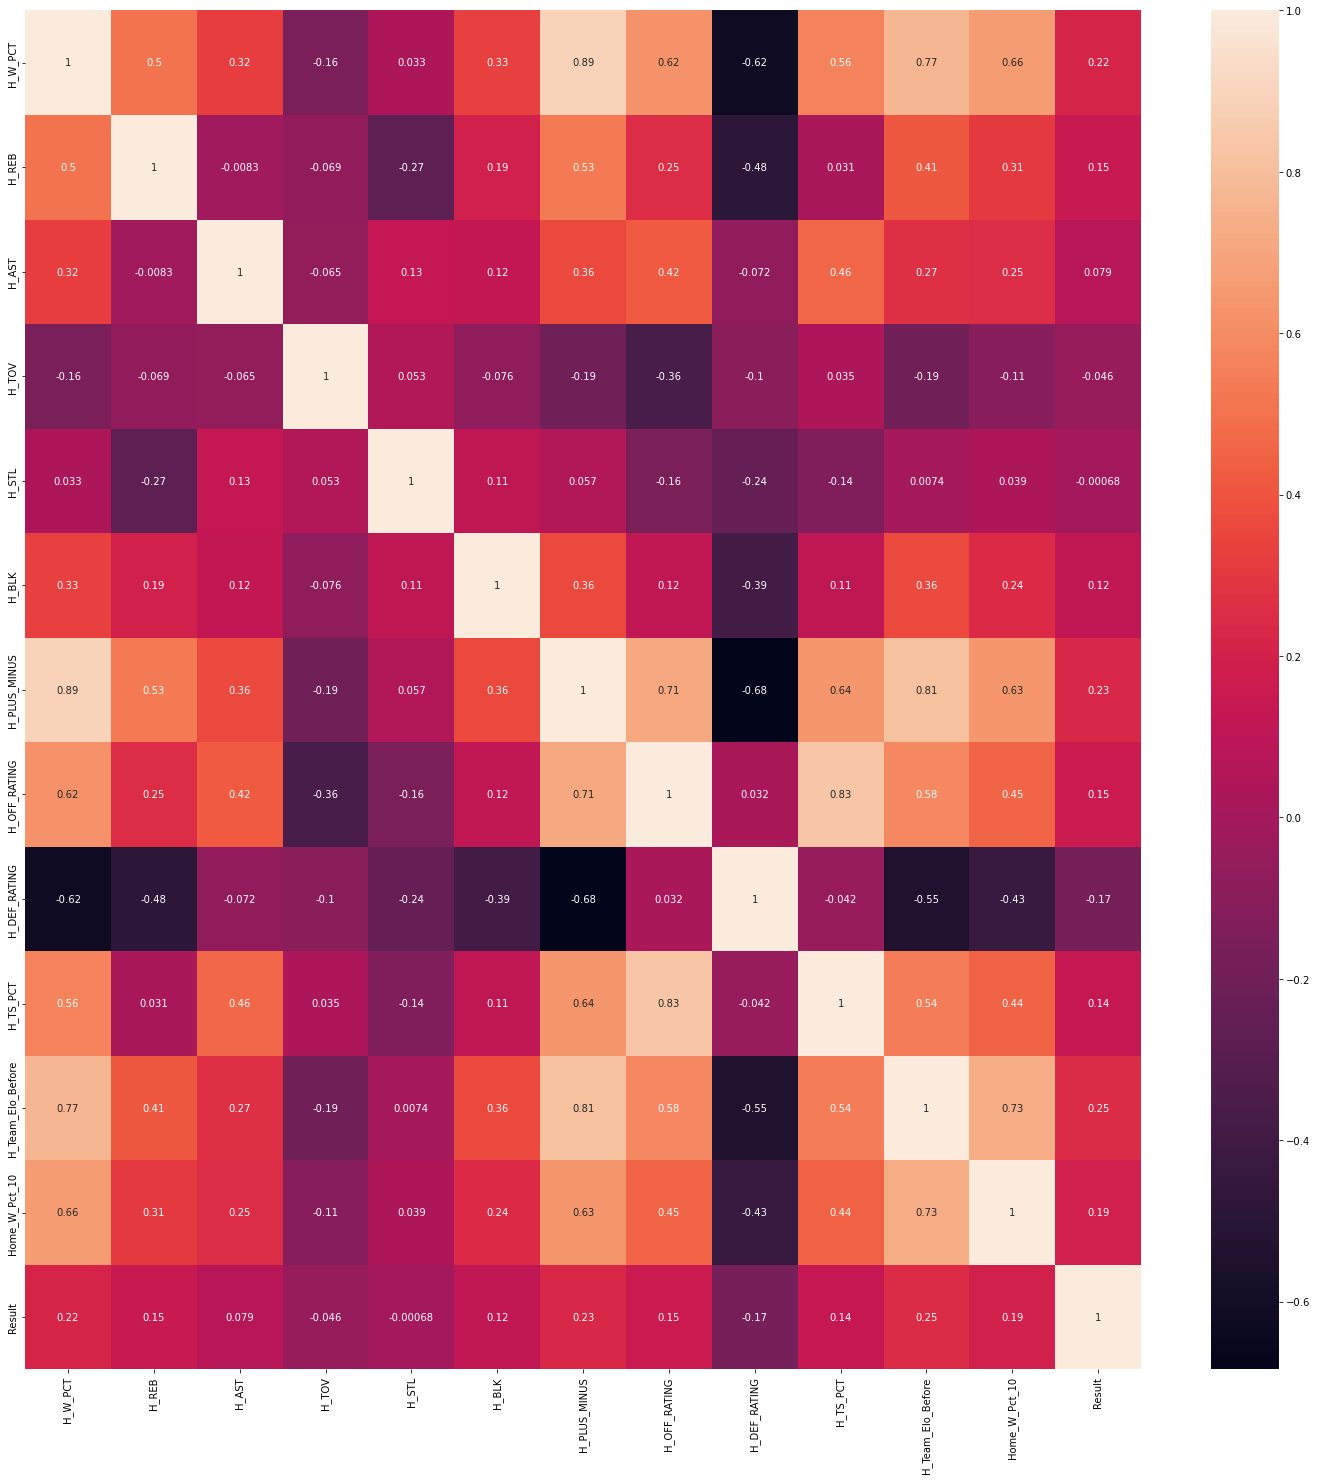

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(25, 25))
correlation = final_df[['H_W_PCT', 'H_REB', 'H_AST',
       'H_TOV', 'H_STL', 'H_BLK', 'H_PLUS_MINUS', 'H_OFF_RATING',
       'H_DEF_RATING', 'H_TS_PCT', 'H_Team_Elo_Before', 'Home_W_Pct_10', 'Result']].corr()
sns.heatmap(correlation, annot=True)
correlation

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#import final dataset
#final_df = pd.read_csv('')

#drop non numeric columns
#df.drop(columns = ['Home', 'Away', 'Game_ID', 'Date', 'Season'], axis = 1, inplace = True )

X = final_df.drop(columns = 'Result')

y = final_df['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f'X train shape: {X_train.shape}')
print(f'X test shape: {X_test.shape}')

X train shape: (2115, 30)
X test shape: (705, 30)


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

#script to test the effectivenes of each model, uses default parameters
#test six different classification models 
def run_exps(X_train, y_train, X_test, y_test) :
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    
    models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier())
        ]
    
    results = []
    
    names = []
    
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    
    target_names = ['win', 'loss']
    
    for name, model in models:
        
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        
        results.append(cv_results)
        names.append(name)
        
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        
    final = pd.concat(dfs, ignore_index=True)
    
    return final
final = run_exps(X_train, y_train, X_test, y_test)
final

LogReg
              precision    recall  f1-score   support

         win       0.56      0.48      0.52       301
        loss       0.65      0.72      0.68       404

    accuracy                           0.62       705
   macro avg       0.60      0.60      0.60       705
weighted avg       0.61      0.62      0.61       705

RF
              precision    recall  f1-score   support

         win       0.58      0.54      0.56       301
        loss       0.67      0.71      0.69       404

    accuracy                           0.64       705
   macro avg       0.63      0.62      0.62       705
weighted avg       0.63      0.64      0.63       705

KNN
              precision    recall  f1-score   support

         win       0.52      0.46      0.49       301
        loss       0.63      0.68      0.65       404

    accuracy                           0.59       705
   macro avg       0.57      0.57      0.57       705
weighted avg       0.58      0.59      0.58       705

SVM
 

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,0.020928,0.003987,0.607565,0.604542,0.607565,0.605388,0.657472,LogReg
1,0.012957,0.003987,0.652482,0.648912,0.652482,0.645543,0.685669,LogReg
2,0.015531,0.003987,0.654846,0.653425,0.654846,0.646748,0.692395,LogReg
3,0.016943,0.003987,0.621749,0.617881,0.621749,0.612874,0.681666,LogReg
4,0.015610,0.003920,0.652482,0.646856,0.652482,0.643915,0.676473,LogReg
5,0.368177,0.030896,0.600473,0.599273,0.600473,0.599789,0.648638,RF
6,0.354135,0.024494,0.624113,0.619805,0.624113,0.619756,0.678506,RF
7,0.353069,0.030321,0.631206,0.627883,0.631206,0.626737,0.677026,RF
8,0.346534,0.031009,0.617021,0.613088,0.617021,0.611908,0.679572,RF
9,0.377934,0.035880,0.612293,0.611136,0.612293,0.611660,0.649346,RF


# Model Performance

In [27]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

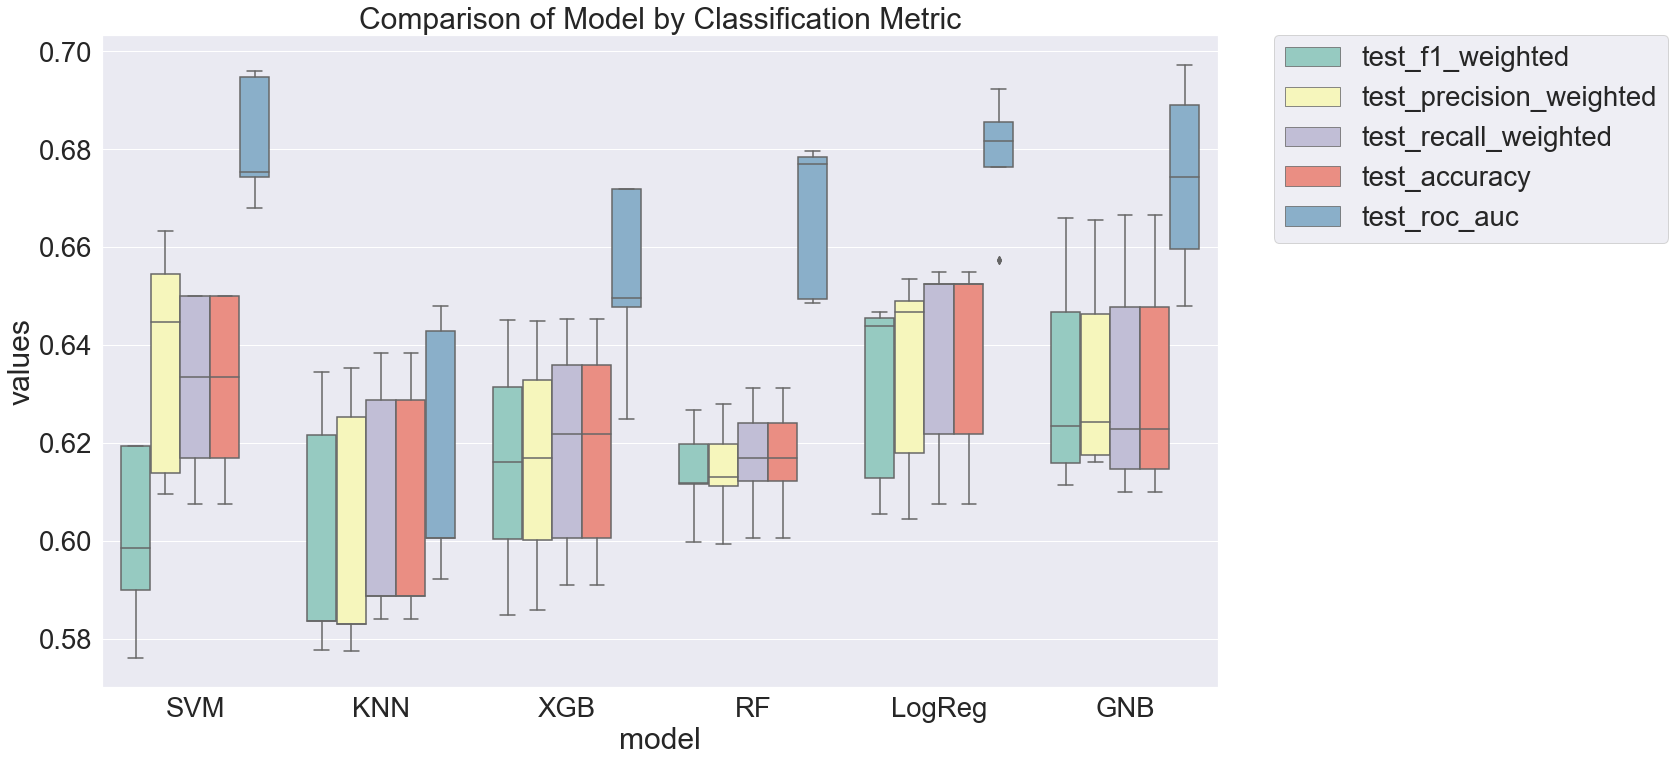

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

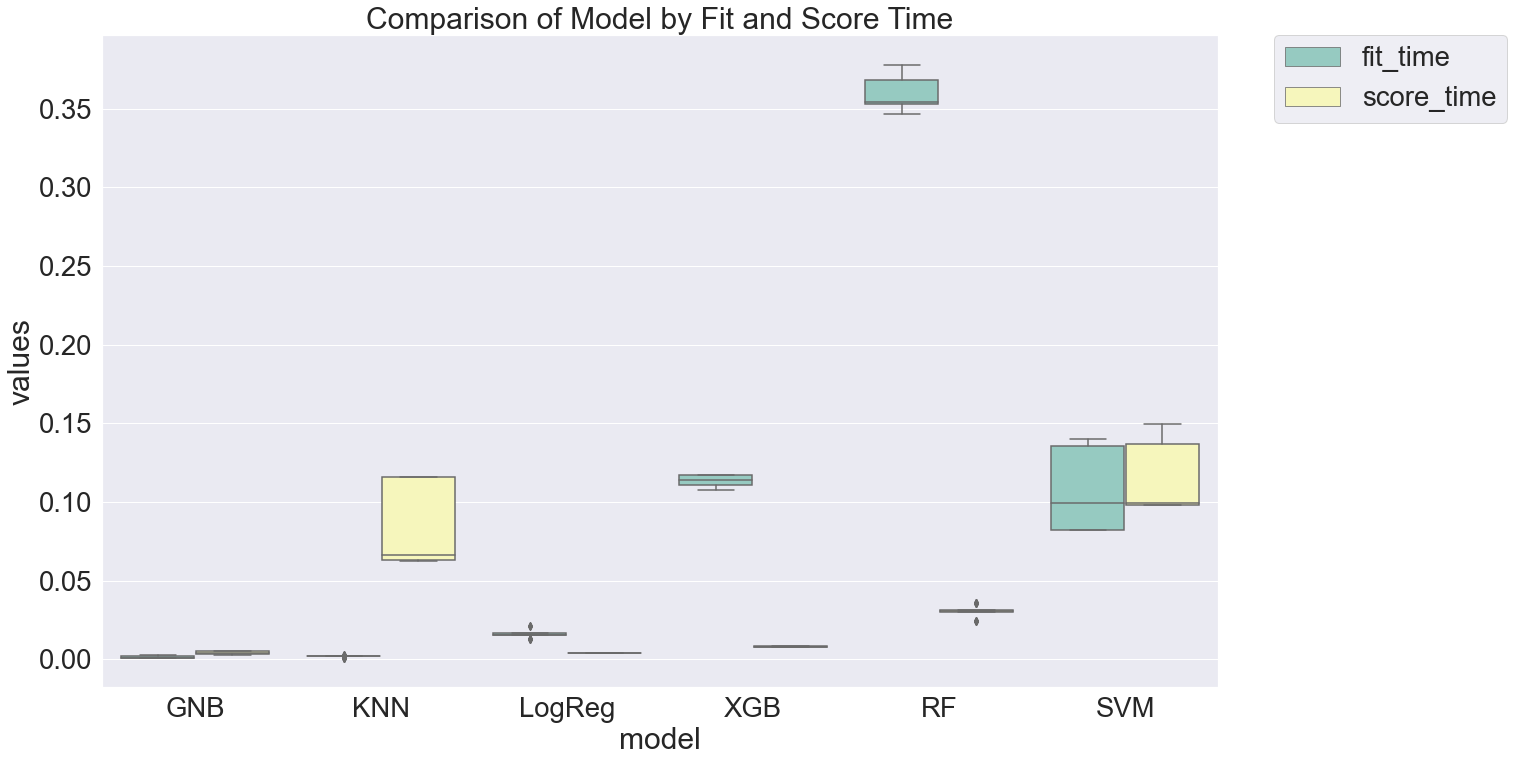

In [29]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

In [30]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_recall_weighted           test_precision_weighted            \
                        std      mean                     std      mean   
model                                                                     
GNB                0.019707  0.629787                0.017105  0.631486   
KNN                0.022177  0.605201                0.023530  0.601019   
LogReg             0.017717  0.640189                0.017621  0.636336   
RF                 0.011336  0.616548                0.010334  0.613981   
SVM                0.016336  0.631994                0.021415  0.637831   
XGB                0.020336  0.619543                0.020740  0.616834   

       test_roc_auc           test_accuracy           test_f1_weighted  \
                std      mean           std      mean              std   
model                                                                    
GNB        0.020070  0.673275      0.019707  0.629787         0.018695   
KNN        0.023050  0.617776      0.022177  0.605201         0.022577   
LogReg     0.009441  0.680144      0.017717  0.640189         0.016943   
RF         0.014805  0.664530      0.011336  0.616548         0.009772   
SVM        0.010956  0.679487      0.016336  0.631994         0.015508   
XGB        0.018100  0.652383      0.020336  0.619543         0.020688   

                  
            mean  
model             
GNB     0.630117  
KNN     0.600593  
LogReg  0.632528  
RF      0.613790  
SVM     0.600775  
XGB     0.616213

# Final Selected Model
- grid search for parameters 
- Gaussian NB

In [32]:
# Gaussian NB only has one parameter 'var_smoothing'
# Portion of the largest variance of all features that is added to variances for calculation stability.
# Number of different combinations of parameters 

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
nb_classifier = GaussianNB()

target_names = ['Win', 'Loss']

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)

gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=kfold,   
                 verbose=1, 
                 scoring='accuracy', n_jobs=-1) 

gs_NB.fit(X_train, y_train)

best_gs_grid = gs_NB.best_estimator_
best_gs_grid.fit(X_train, y_train)
y_pred_best_gs = best_gs_grid.predict(X_test)

print(classification_report(y_test, y_pred_best_gs, target_names=target_names))
gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
              precision    recall  f1-score   support

         Win       0.59      0.44      0.50       301
        Loss       0.65      0.77      0.71       404

    accuracy                           0.63       705
   macro avg       0.62      0.61      0.61       705
weighted avg       0.62      0.63      0.62       705



{'var_smoothing': 0.0533669923120631}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
mean_rf_cv_score = cross_val_score(rf_clf, 
                                   X_train, 
                                   y_train, 
                                   cv=10)

mean_rf_cv_score = np.mean(mean_rf_cv_score)

print(f"Mean Cross Validation Score for Random Forest Classifier: {np.round(mean_rf_cv_score * 100, 2)}%")

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB(random_state=42)
gnb_rf_cv_score = cross_val_score(gnb,
                                  X_train,
                                  y_train,
                                  cv=10)

mean_rf_cv_score = np.mean(mean_rf_cv_score)



print(f"Mean Cross Validation Score for Random Forest Classifier: {np.round(mean_rf_cv_score * 100, 2)}%")

In [ ]:
rf_param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100),
    #'var_smoothing': [1e-11, 1e-10, 1e-9]
}

In [ ]:
rf_grid_search = GridSearchCV(estimator=rf_clf,
                             param_grid=rf_param_grid,
                             cv=3,
                             return_train_score=True)

rf_grid_search.fit(X_train, y_train)

# Mean training score
rf_gs_training_score = np.mean(rf_grid_search.cv_results_['mean_train_score'])

# Mean test score
rf_gs_testing_score = rf_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {rf_gs_training_score:.2%}\n")
print(f"Mean Test Score: {rf_gs_testing_score:.2%}\n")

print("Best Parameter Combination Found During Grid Search:")
print(f"Optimal Parameters: {rf_grid_search.best_params_}\n")
print(f"Testing Accuracy: {rf_grid_search.best_score_:.2%}\n")


best_gnb_grid = rf_grid_search.best_estimator_
best_gnb_grid.fit(X_train, y_train)
y_pred_gnb = best_gnb_grid.predict(X_test)

print(classification_report(y_test, y_pred_gnb))

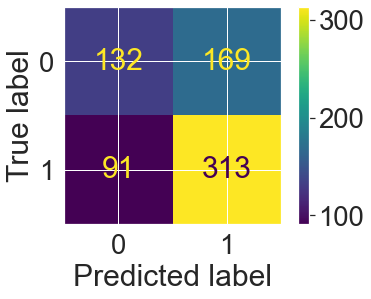

In [41]:

# Plot a confusion matrix on the test data
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(gs_NB, X_test, y_test);

# Confusion Matrix

In [46]:
#confusionMatrix = metrics.confusion_matrix(Y_test, Y_pred)  
#from sklearn.metrics import ConfusionMatrixDisplay

#ConfusionMatrixDisplay.from_estimator(gs_NB, y_test, y_pred_best_gs).reshape(-1, 1);

    # Code below prints model accuracy information
print('Coefficient Information:')

for i in range(len(X_test.columns)):  

    logregCoefficients = logreg.coef_

    currentFeature = featureColumns[i]
    currentCoefficient = logregCoefficients[0][i]

    print(currentFeature + ': ' + str(currentCoefficient))

print('----------------------------------')

print("Accuracy:", metrics.accuracy_score(y_test, y_pred_best_gs))
print("Precision:", metrics.precision_score(y_test, y_pred_best_gsd))
print("Recall:", metrics.recall_score(y_test, y_pred_best_gs))

print('----------------------------------')

print('Confusion Matrix:')
print(confusionMatrix)

Coefficient Information:


NameError: name 'logreg' is not defined

# Saving Model

In [ ]:
import pickle

# Saves the model in folder to be used in future
# filename should be end in '.pkl'
def save_model(model, filename):

    with open(filename, 'wb') as file:
        pickle.dump(model, file)
save_model()